In [1]:
import os
os.chdir(os.path.expanduser("~/phd/phd_nbeats_with_feature_vector"))

import neurokit2 as nk
import numpy as np
import sklearn as sk
from challenge import *
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import math
import ecg_plot
import pywt
from scipy.signal import find_peaks
import functools
import operator
from sklearn import tree
import seaborn as sns
import scipy 
import time

from pybaselines import Baseline
from pybaselines.classification import dietrich, std_distribution, cwt_br, fabc


def clean_labels(header):
    logger.debug(f"Clean label for header file: {header}")
    classes_from_header = get_labels(header)
    
    logger.debug(f"Classes found in header: {classes_from_header}")
    if '733534002' in classes_from_header:
        classes_from_header[classes_from_header.index('733534002')] = '164909002'
        classes_from_header = list(set(classes_from_header))
    if '713427006' in classes_from_header:
        classes_from_header[classes_from_header.index('713427006')] = '59118001'
        classes_from_header = list(set(classes_from_header))
    if '63593006' in classes_from_header:
        classes_from_header[classes_from_header.index('63593006')] = '284470004'
        classes_from_header = list(set(classes_from_header))
    if '427172004' in classes_from_header:
        classes_from_header[classes_from_header.index('427172004')] = '17338001'
        classes_from_header = list(set(classes_from_header))

    return classes_from_header

data_directory="../data/physionet.org/files/challenge-2021/1.0.3/training/ptb/g1"
leads = ('I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6')

xls = pd.ExcelFile('label_mappings.xlsx')
df = pd.read_excel(xls, 'PTB')

df_labels_to_class_list=df[['SNOMED code','Diagnosis in the dataset']].set_index('SNOMED code').apply(lambda row: {row.name: row.values.tolist()[0]}, axis=1).tolist()
labels_to_class= reduce(lambda a, b: a|b, df_labels_to_class_list)

header_files, recording_files = find_challenge_files(data_directory)
num_recordings = len(header_files)

def build_dict_for_labels(labels, header_files, recording_files):
    result = {}
    for i in range(len(header_files)):
        header = load_header(header_files[i])
        current_labels= clean_labels(header)
        if current_labels[0] not in result:
            result[current_labels[0]] = [(header_files[i], recording_files[i])]
        else:
            result[current_labels[0]].append((header_files[i], recording_files[i]))
    return result

files_per_label = build_dict_for_labels(labels_to_class.keys(), header_files, recording_files)      

In [2]:
def baseline_wandering_removal(signal, wavelet, level):
    N = len(signal[0])
    coeffs = pywt.wavedec(data=signal, wavelet=wavelet, level=level)
    reconstructed_approximates = [pywt.upcoef('a', coeffs[0][i], wavelet, level=level)[:N] for i in range(len(signal))]
    result = signal - reconstructed_approximates
    return result, coeffs


Text(0, 0.5, 'Power mV')

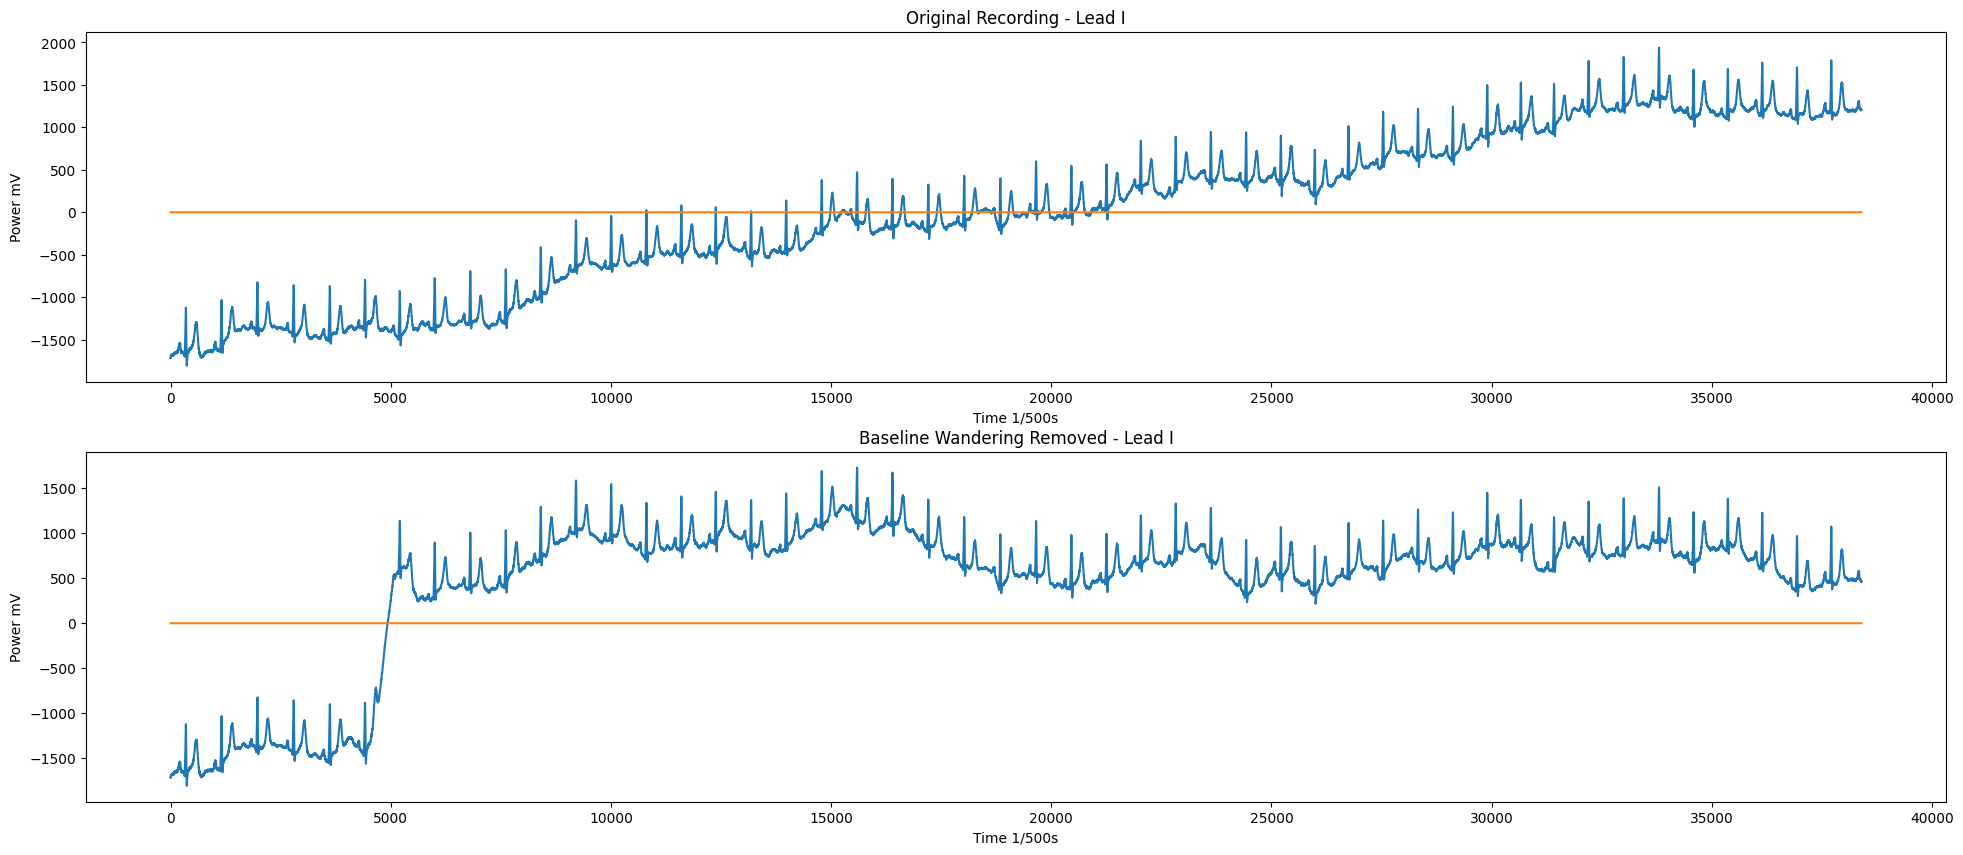

In [3]:
header_file, recording_file = files_per_label['6374002'][1]
header= load_header(header_file)
recording = np.array(load_recording(recording_file), dtype=np.float32)
(exemplar_singal_with_bw_removed, _) = baseline_wandering_removal(recording, 'sym10', 9)
figure, axis = plt.subplots(2, 1)
figure.set_size_inches(24,10)

axis[0].plot(range(len(recording[0])), recording[0])
axis[0].plot(range(len(recording[0])), np.zeros(len(recording[0])))
axis[0].title.set_text("Original Recording - Lead I")
axis[0].set_xlabel('Time 1/500s')
axis[0].set_ylabel('Power mV')
axis[1].plot(range(len(exemplar_singal_with_bw_removed[0])), exemplar_singal_with_bw_removed[0])
axis[1].plot(range(len(exemplar_singal_with_bw_removed[0])), np.zeros(len(exemplar_singal_with_bw_removed[0])))
axis[1].title.set_text("Baseline Wandering Removed - Lead I")
axis[1].set_xlabel('Time 1/500s')
axis[1].set_ylabel('Power mV')

In [4]:
x = range(len(recording[0][:10000]))
y = recording[0][:10000]
baseline_fitter = Baseline(x_data=x)
bkg_1, params_1 = baseline_fitter.modpoly(y, poly_order=3)
bkg_2, params_2 = baseline_fitter.asls(y, lam=1e7, p=0.02)
bkg_3, params_3 = baseline_fitter.mor(y, half_window=30)
st = time.time()
bkg_4, params_4 = baseline_fitter.snip(
    y, max_half_window=45, decreasing=True, smooth_half_window=4
)
et=time.time()

print(f"single param processing time: {et-st}")
print(f"modpoly bkg: {bkg_1}")
print(f"modpoly params: {params_1}")
print(f"modpoly bkg len: {len(bkg_1)}")
print(f"recording len: {len(y)}")

single param processing time: 0.004947185516357422
modpoly bkg: [-1821.3062  -1821.0742  -1820.8425  ...  -613.0514   -612.62445
  -612.1974 ]
modpoly params: {'weights': array([1., 1., 1., ..., 1., 1., 1.]), 'tol_history': array([0.03587757, 0.01804818, 0.0119519 , 0.0087269 , 0.00674452,
       0.00541285, 0.00444306, 0.0037056 , 0.00313456, 0.00269406,
       0.00234843, 0.0020667 , 0.00183217, 0.00163461, 0.001467  ,
       0.00132404, 0.00120064, 0.00109292, 0.0009989 ])}
modpoly bkg len: 10000
recording len: 10000


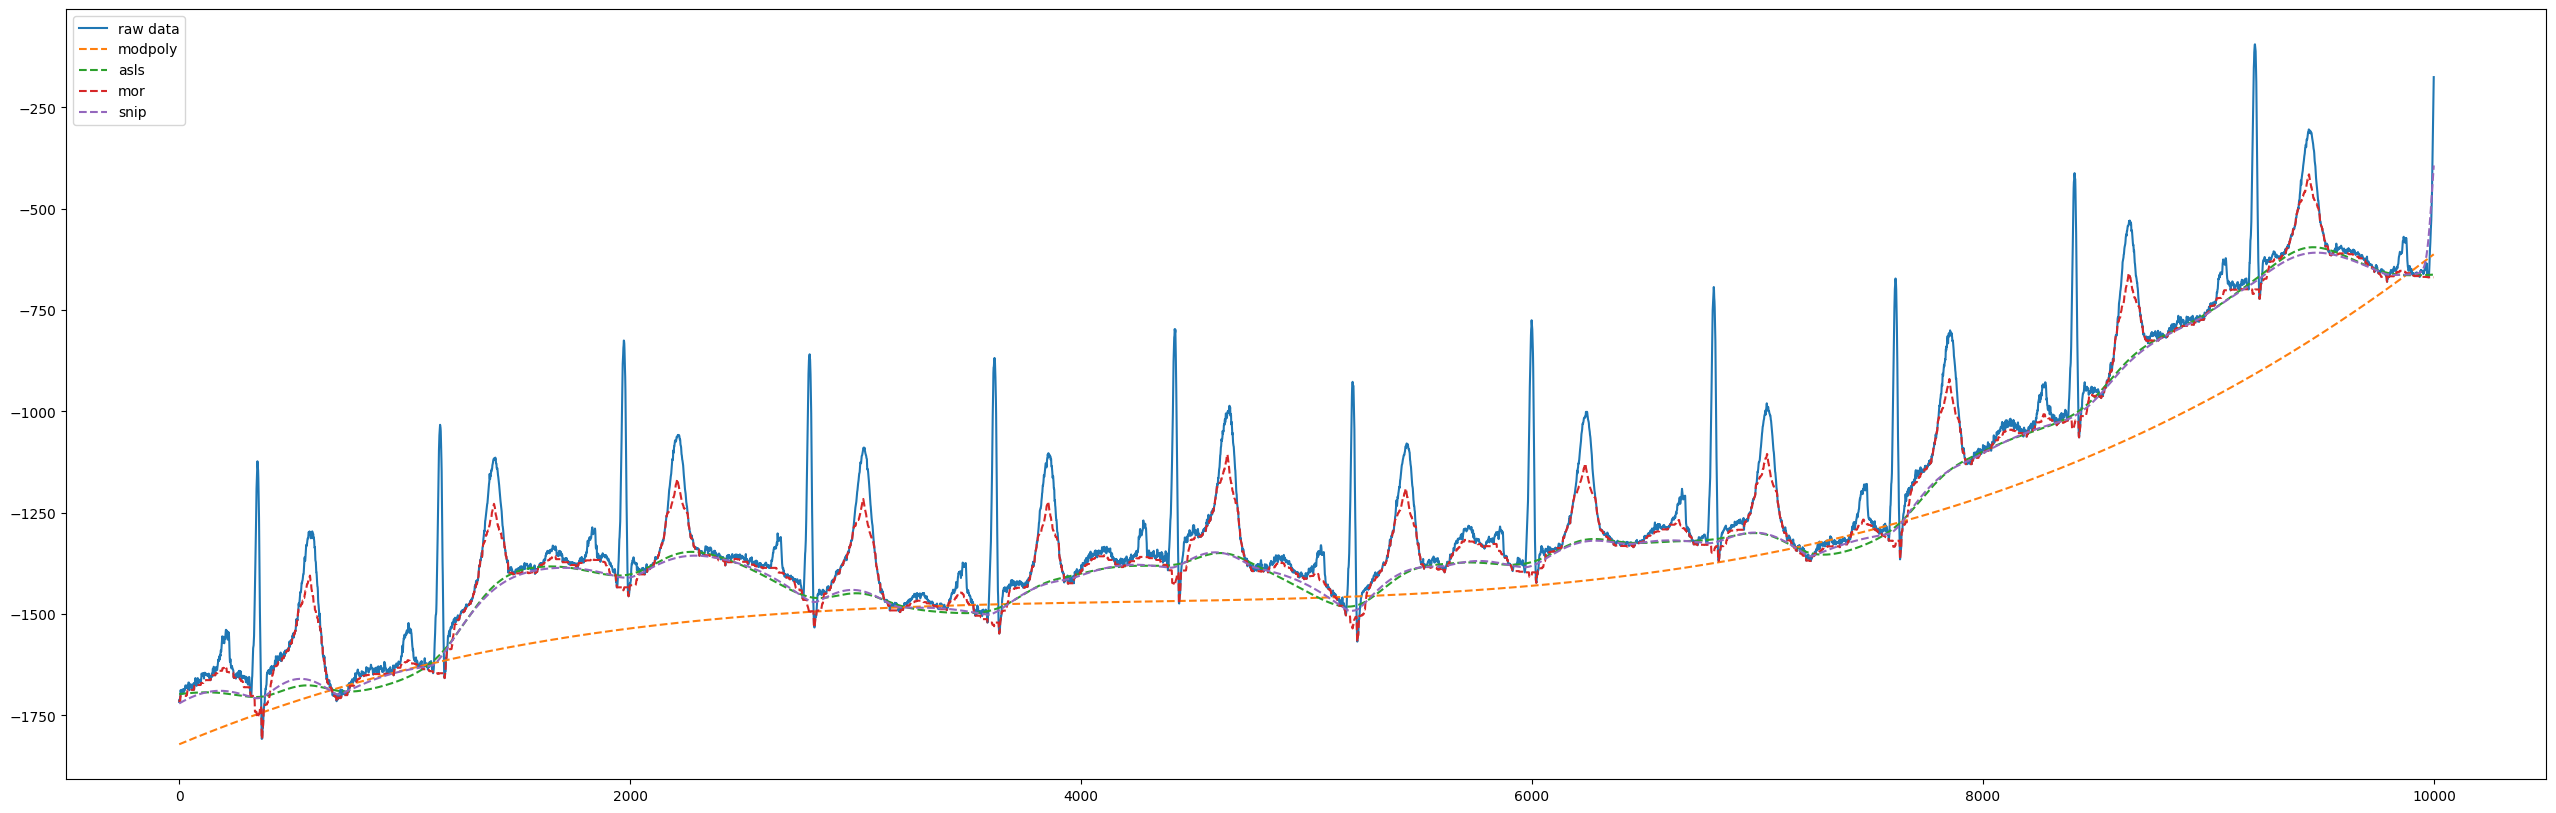

In [5]:

plt.plot(x, y, label='raw data', lw=1.5)
plt.plot(x, bkg_1, '--', label='modpoly')
plt.plot(x, bkg_2, '--', label='asls')
plt.plot(x, bkg_3, '--', label='mor')
plt.plot(x, bkg_4, '--', label='snip')
fig = plt.gcf()
fig.set_size_inches(32,10)
plt.legend()
plt.show()

In [6]:
x = range(len(recording[0][:10000]))
y = recording[0][:10000]
st = time.time()
baseline_fitter = Baseline(x_data=x)
bkg_1, params_1 = baseline_fitter.fabc(y, poly_order=3)
et=time.time()
bkg_2, params_2 = baseline_fitter.dietrich(y)
bkg_3, params_3 = baseline_fitter.std_distribution(y)
bkg_4, params_4 = baseline_fitter.cwt_br(y)
print(f"single param processing time: {et-st}")
print(f"modpoly bkg: {bkg_1}")
print(f"modpoly params: {params_1}")
print(f"modpoly bkg len: {len(bkg_1)}")
print(f"recording len: {len(y)}")

single param processing time: 0.04843306541442871
modpoly bkg: [-1699.4207  -1698.9928  -1698.5648  ...  -459.60944  -456.66663
  -453.7235 ]
modpoly params: {'mask': array([ True,  True,  True, ...,  True,  True,  True]), 'weights': array([ True,  True,  True, ...,  True,  True,  True])}
modpoly bkg len: 10000
recording len: 10000


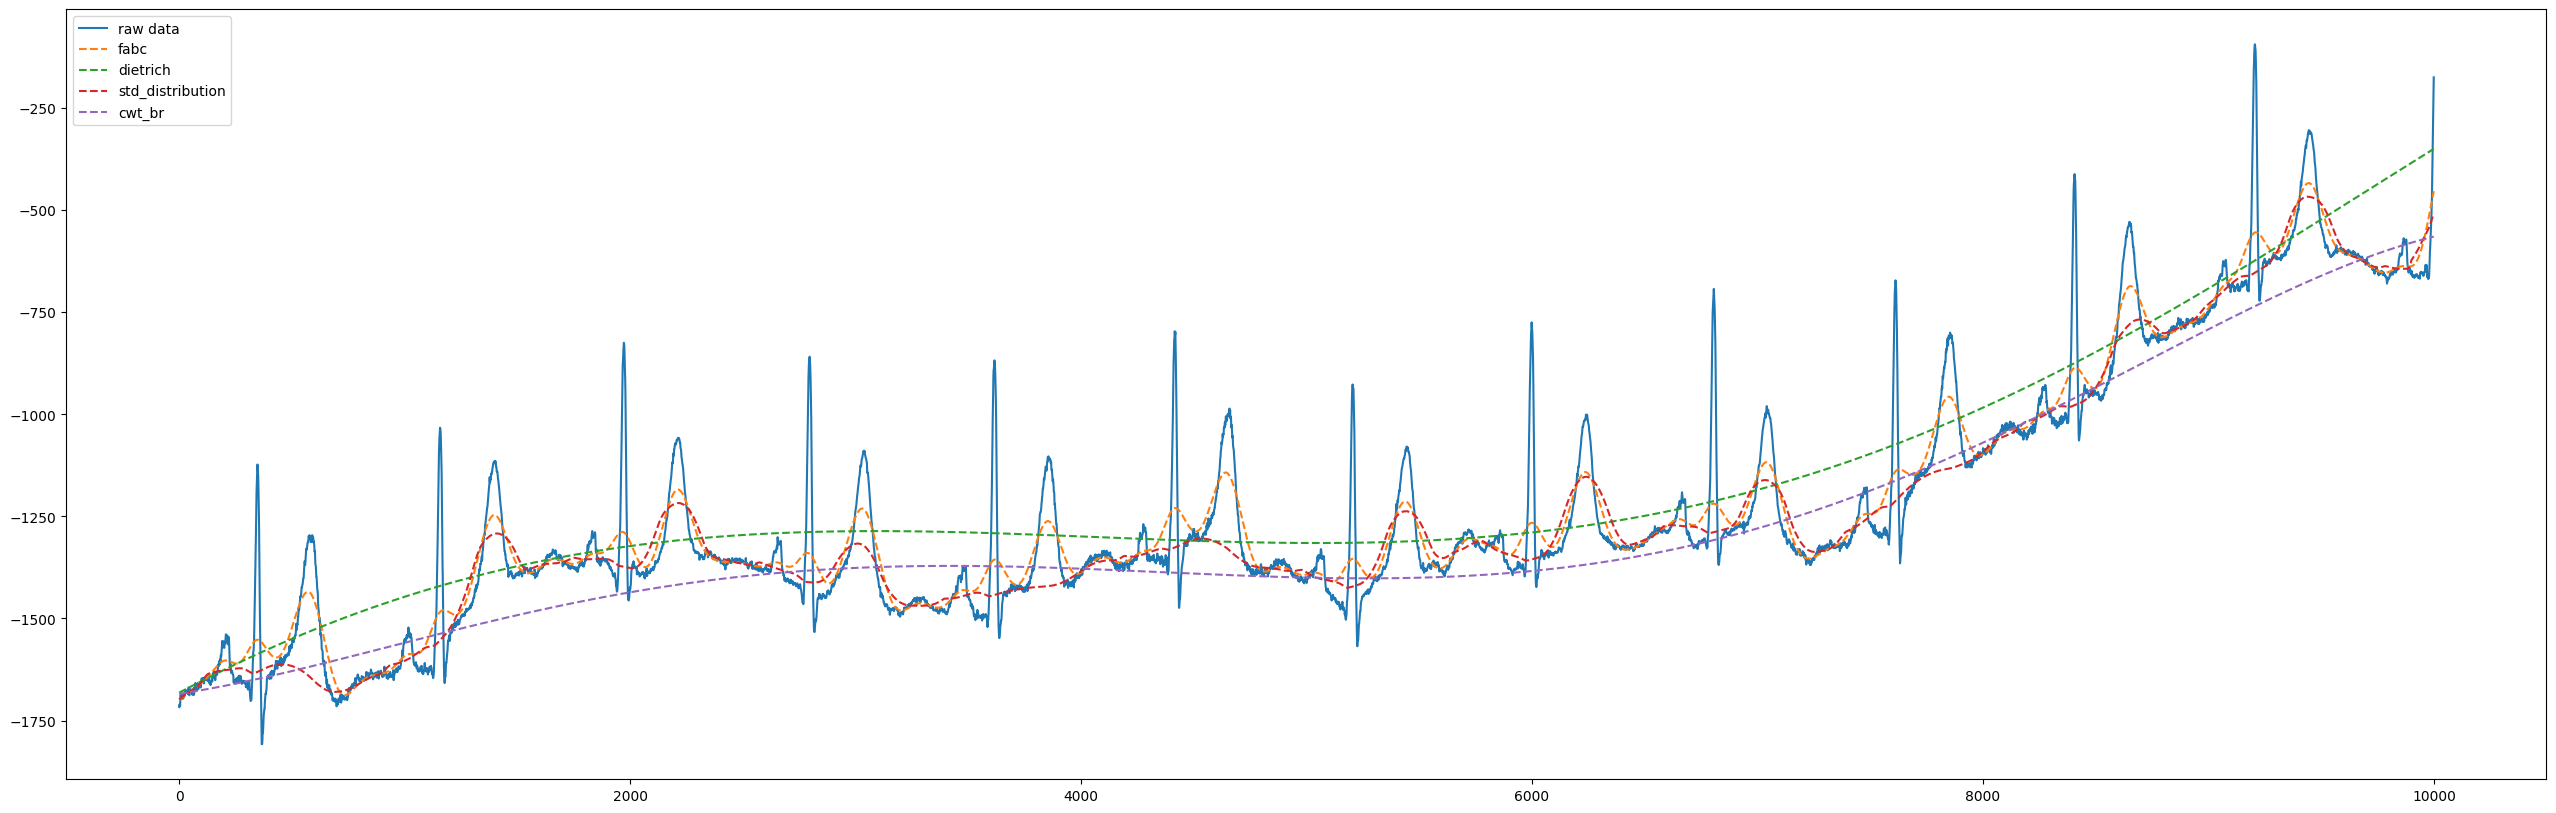

In [7]:
plt.plot(x, y, label='raw data', lw=1.5)
plt.plot(x, bkg_1, '--', label='fabc')
plt.plot(x, bkg_2, '--', label='dietrich')
plt.plot(x, bkg_3, '--', label='std_distribution')
plt.plot(x, bkg_4, '--', label='cwt_br')
fig = plt.gcf()
fig.set_size_inches(32,10)
plt.legend()
plt.show()

# Selected baseline detection - snip


Text(0, 0.5, 'Power mV')

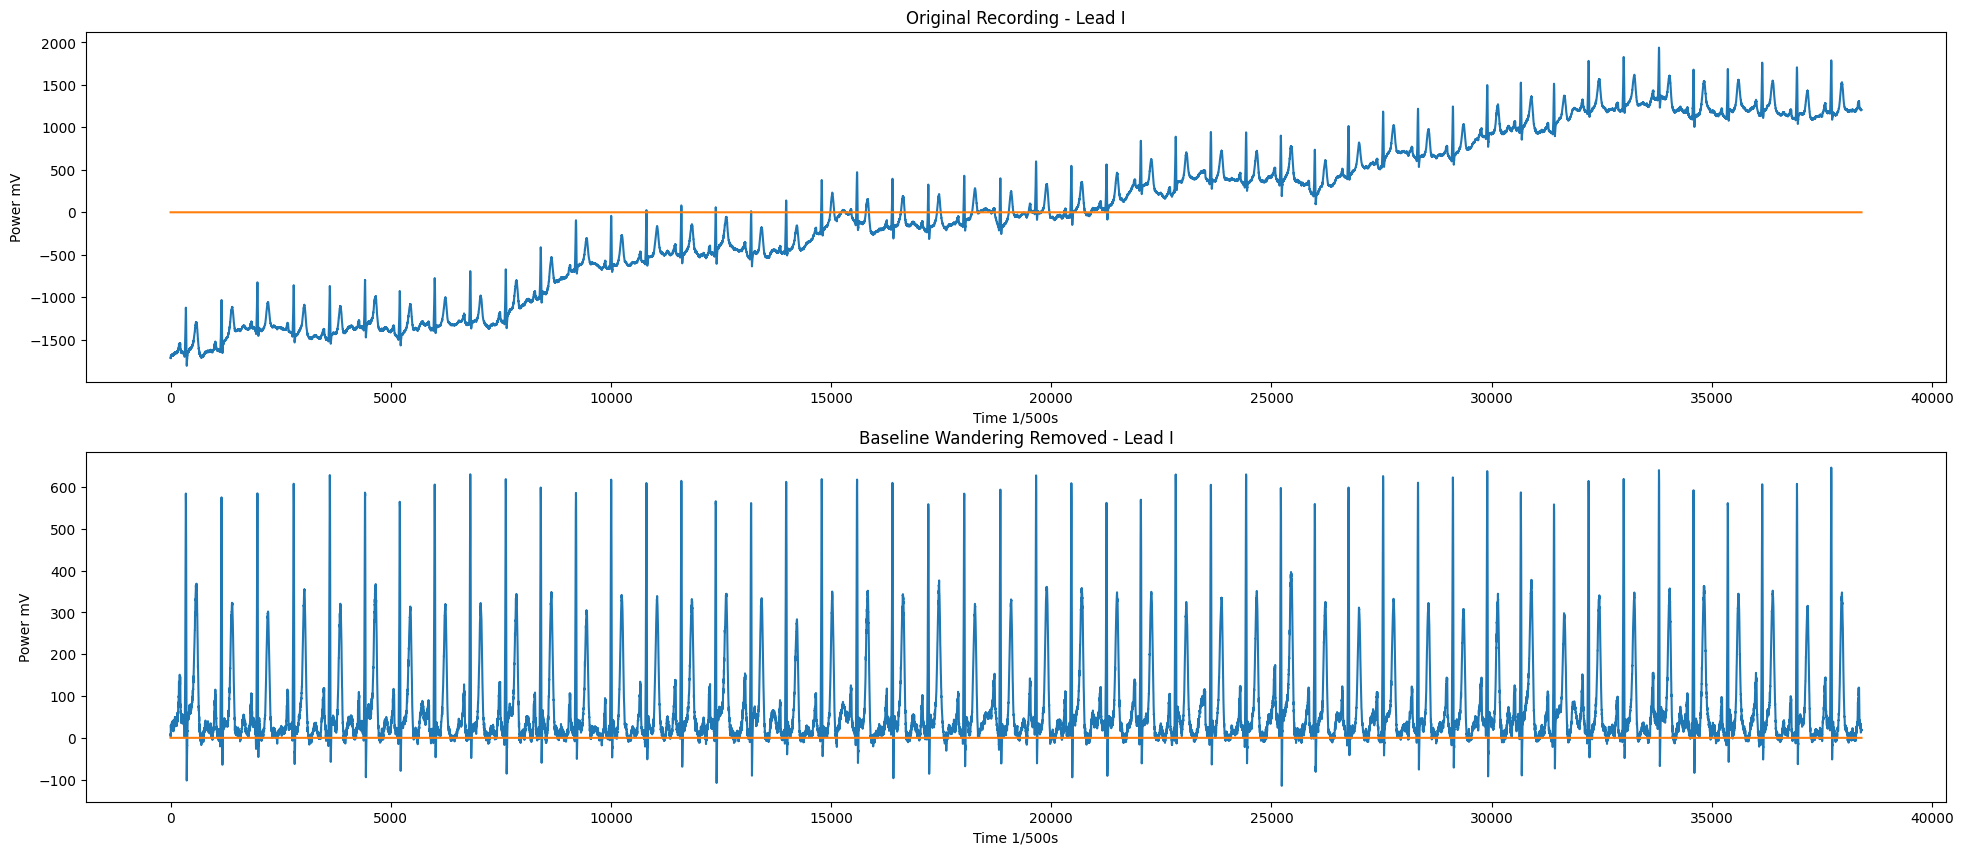

In [8]:
x = range(len(recording[0]))
y = recording[0]
baseline_fitter = Baseline(x_data=x)
bkg, params = baseline_fitter.snip(
    y, max_half_window=45, decreasing=True, smooth_half_window=4
)
bkg_to_equalise = bkg * -1

equalised = y+bkg_to_equalise

figure, axis = plt.subplots(2, 1)
figure.set_size_inches(24,10)
axis[0].plot(x, y)
axis[0].plot(x, np.zeros(len(x)))
axis[0].title.set_text("Original Recording - Lead I")
axis[0].set_xlabel('Time 1/500s')
axis[0].set_ylabel('Power mV')
axis[1].plot(x, equalised)
axis[1].plot(x, np.zeros(len(x)))
axis[1].title.set_text("Baseline Wandering Removed - Lead I")
axis[1].set_xlabel('Time 1/500s')
axis[1].set_ylabel('Power mV')

In [12]:
sorted(files_per_label.keys())

['164865005',
 '164889003',
 '164890007',
 '164895002',
 '164896001',
 '204384007',
 '266249003',
 '282825002',
 '314208002',
 '368009',
 '426783006',
 '53741008',
 '6374002',
 '698247007',
 '84114007']

Text(0, 0.5, 'Power mV')

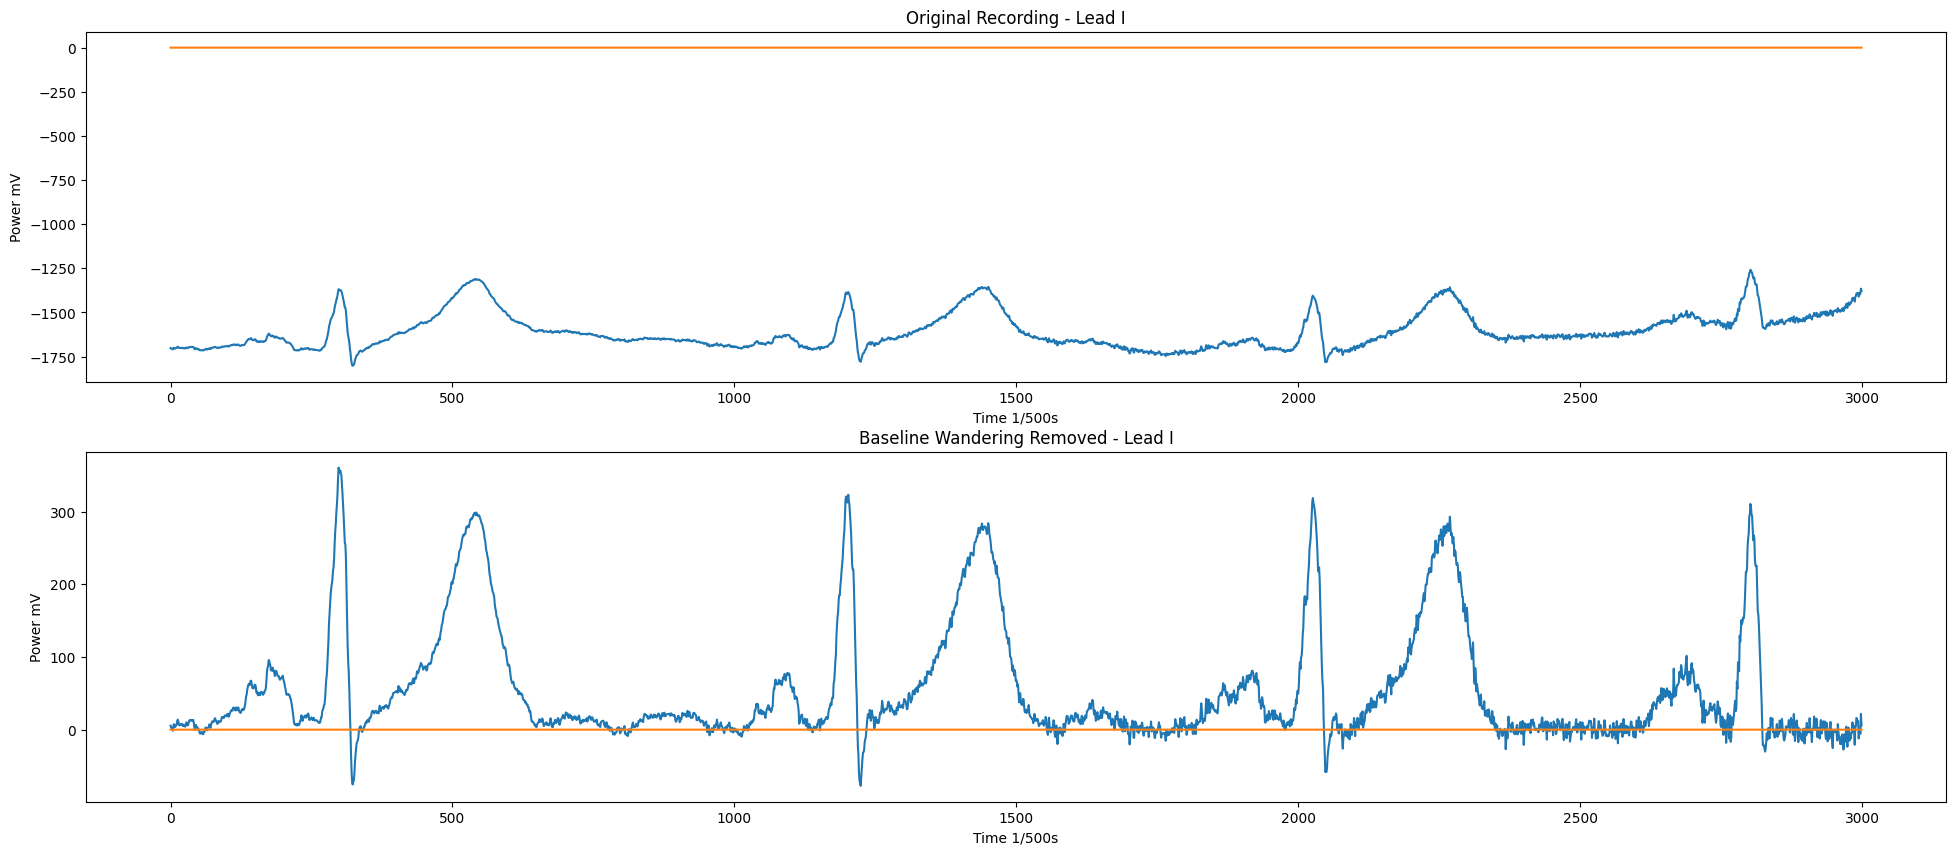

In [19]:
header_file, recording_file = files_per_label['426783006'][1]
header= load_header(header_file)
recording = np.array(load_recording(recording_file), dtype=np.float32)
x = range(len(recording[0][:3000]))
y = recording[0][:3000]
baseline_fitter = Baseline(x_data=x)
bkg, params = baseline_fitter.snip(
    y, max_half_window=45, decreasing=True, smooth_half_window=4
)
bkg_to_equalise = bkg * -1

equalised = y+bkg_to_equalise

figure, axis = plt.subplots(2, 1)
figure.set_size_inches(24,10)
axis[0].plot(x, y)
axis[0].plot(x, np.zeros(len(x)))
axis[0].title.set_text("Original Recording - Lead I")
axis[0].set_xlabel('Time 1/500s')
axis[0].set_ylabel('Power mV')
axis[1].plot(x, equalised)
axis[1].plot(x, np.zeros(len(x)))
axis[1].title.set_text("Baseline Wandering Removed - Lead I")
axis[1].set_xlabel('Time 1/500s')
axis[1].set_ylabel('Power mV')